# Spaceship.

## Task description

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

## Files and Data Fields Descriptions


### **train.csv**  - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.

Your task is to predict the value of Transported for the passengers in this set.

### **sample_submission.csv** - A submission file in the correct format.

PassengerId - Id for each passenger in the test set.

Transported - The target. For each passenger, predict either True or False.



### Here are the first 5 rows of the data:

In [971]:
import pandas as pd

# Random seed for reproducibility
SEED = 123
# A file to save global variables
global_variables = pd.DataFrame({'SEED': [SEED]})
global_variables.to_csv('global_variables.csv')
global_variables.to_csv('functions/global_variables.csv')

train_unprocessed = pd.read_csv('datasets/train.csv')
test_unprocessed = pd.read_csv('datasets/test.csv')

train_size = len(train_unprocessed)
train_size_file = pd.DataFrame([train_size])
train_size_file.to_csv('train_size.csv')

# Collect Passenger Ids in the test dataset into a separate variable
test_Ids = test_unprocessed['PassengerId']
test_Ids.to_csv('test_Ids.csv')

data_unprocessed = pd.concat([train_unprocessed, test_unprocessed]).reset_index(drop=True)

data_unprocessed.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

  Transported  
0       False  
1        True  
2       False  
3       False  
4        True

In [972]:
data_unprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


## 00. Baseline

First, we'll make a baseline prediction, that all passengers were Transported. We'll calculate the Score of this prediction on the train set (for future cases, we'll calculate separately Train Score and Cross-validation Score, but in this case, these scores will be equal to Train Score, since our cross-validation will be stratified).

Our Score = (Average Cross-validation ROC AUC) - (1 Standard deviation of Cross-validation ROC AUCs).

In this simple case, Standard deviation will be 0 (again, cross-validation is stratified), so Score for this case will be just Train ROC AUC.

We'll save our intermediate results in DataFrame scores_df:

In [973]:
from sklearn.metrics import roc_auc_score

train_predictions_00 = pd.DataFrame(data=train_unprocessed['Transported'], columns=['Transported'])
train_predictions_00['Transported'] = True

scores_df = pd.DataFrame({'Comment': [], 'Train Score': [], 'Cross-val Score': [], 'Test Accuracy': []})

score_00 = roc_auc_score(train_unprocessed['Transported'], train_predictions_00['Transported'])

scores_df.loc[0, 'Comment'] = 'All True'
scores_df.loc[0, 'Train Score'] = score_00
scores_df.loc[0, 'Cross-val Score'] = score_00
scores_df

Comment  Train Score  Cross-val Score  Test Accuracy
0  All True          0.5              0.5            NaN

ROC AUC is 0.5, which means our predictions are no better than random guessing

Now, we'll make a submission to Kaggle to see our Test Accuracy. We won't use Test Accuracy in making decisions, but we'll use it to catch bugs in our Score calculations:

In [974]:
test_predictions_00 = pd.DataFrame([True] * len(test_unprocessed), columns=['Transported'])
submission_00 = pd.concat([test_unprocessed['PassengerId'], test_predictions_00], axis=1)

submission_00.to_csv('submissions/submission_00.csv', index=False)

scores_df.loc[0, 'Test Accuracy'] = 0.50689
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  Cross-val Score  Test Accuracy
0  All True          0.5              0.5        0.50689

## 01. Numerical features with 0's for missing values

Now, we'll make predictions on the numerical features only, filling missing values with zeros:

In [975]:
# Drop non-numerical columns
train = train_unprocessed.select_dtypes(include=['int', 'float'])
test = test_unprocessed.select_dtypes(include=['int', 'float'])

# Put the target variable back to the train dataset
train = pd.concat([train, train_unprocessed['Transported']], axis=1)

# Fill missing values with zeros
train = train.fillna(0)
test = test.fillna(0)

train.to_csv('new_datasets/train_01.csv')
test.to_csv('new_datasets/test_01.csv')


We'll use XGBoost with default parameters as our first estimator. 

### Choosing number of cross-validation splits

For calculating Score, I wrote get_score function, that is located in ['functions/get_score.py'](functions/get_score.py). This function takes a number of StratifiedKFold slits as one of its arguments. 

We want such number of splits that give us the best balance between bias and variance. For the sake of run time, the optimal number of splits calculation is done in a separate file: ['functions/n_splits.py'](functions/n_splits.py).

The tradeoff sweetspot is at 3 splits.

In [976]:
N_SPLITS = 3
global_variables['N_SPLITS'] = N_SPLITS
global_variables.to_csv('global_variables.csv')
global_variables.to_csv('functions/global_variables.csv')

Let's find Scores and Test Accuracy for this number of splits:

In [977]:
# UNCOMMENT TO INSTALL XGBOOST
#!pip install xgboost
import xgboost as xgb

# Instantiate the classifier
model = xgb.XGBClassifier(random_state=SEED, n_jobs=-1)

from functions.get_score import get_score

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train, test, model, scores_df,
                                                                  comment="All numerical features with 0's for missing values")

In [978]:
submission.to_csv('submissions/submission_01.csv', index=False)

scores_df.loc[1, 'Test Accuracy'] = 0.7877
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  \
0                                           All True     0.500000   
1  All numerical features with 0's for missing va...     0.919507   

   Cross-val Score  Test Accuracy  
0         0.500000        0.50689  
1         0.828452        0.78770

## Hyperparameters tuning workflow description

For the sake of runtime and for convinience, we'll do all our hyperparameters tunings in separate files. Here is the workflow:

-) Notice the Report chapter number. For example, our next chapter, in which we'll do our first tining, is 02.

-) If you need to restart any study from scratch, go to ['functions/initialize_studies.ipynb'](functions/initialize_studies.ipynb), run the first cell to import packages, then run a cell with your current Report chapter number. The progress of that study will be deleted.

!!!ATTENTION!!! Do not run the whole initialize_studies notebook, or all the studies will be restarted (unless that is what you want). !!!ATTENTION!!!

-) The current study is in studies/Report_chapter_number.py. For example, next study will be in ['studies/02.py'](studies/02.py).

-) At the beginning of the study file, choose maximum run time and number of trials for the current run.

-) Hyperparameter tuning will be continued from the end of the previous run of this file.

-) At the end of the run, look at the best parameters. If some of the parameters are on the extreme ends of the search ranges, extend the ranges. The study progress will be kept.

-) At the end of the run, look at the total number of trials in study and the number of the best trial.

-) If results (Average cross-val scores) keep going up, re-run the file. Repeat until satisfied.

-) If results (Average cross-val scores) do not improve for a big number of trials, then go back to the current Report chapter and load results (see below).

For a simple exaple look at ['studies/test.ipynb'](studies/test.ipynb). This study maximizes sum of two numbers chosen from a set of integers.

## 02. Choosing numerical features

We'll find the set of numerical features that gives us the highest cross-validation Score:

In [979]:
import joblib
import optuna

study = joblib.load("studies/02.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8284518468994545
Best hyperparameters: {'Age': True, 'RoomService': True, 'FoodCourt': True, 'ShoppingMall': True, 'Spa': True, 'VRDeck': True}


Here, "'Age': True" means that the best model was using 'Age' feature. 

All the features were selected by our hyperparameters search.

Note, that our best Score is equal to the Score from the 01, since we used the same set of features and same random seed. Let's put this score into scores_df for consistency:

In [980]:
train_score, cross_score, cross_scores_std, submission = get_score(global_variables, train, test, model, scores_df,
                                                                  comment="All numerical features are selected")
scores_df.loc[2, 'Test Accuracy'] = 0.7877
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  \
0                                           All True     0.500000   
1  All numerical features with 0's for missing va...     0.919507   
2                All numerical features are selected     0.919507   

   Cross-val Score  Test Accuracy  
0         0.500000        0.50689  
1         0.828452        0.78770  
2         0.828452        0.78770

## Categorical features

Let's look at our data column by column:

## 03. Group Size

**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

The number of a passenger within their group is arbitrary, so we don't need it. However, group numbers may be important, so we'll create a new feature "Group":

In [981]:
train['Group'] = train_unprocessed['PassengerId'].str[:4]
test['Group'] = test_unprocessed['PassengerId'].str[:4]
print(train['Group'].info())
print(train['Group'].describe())
print('Unique Values:')
print(train['Group'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Group
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count     8693
unique    6217
top       4498
freq         8
Name: Group, dtype: object
Unique Values:
['0001' '0002' '0003' ... '9278' '9279' '9280']


We have 6217 separate Groups in the training set among 8693 entries.

We need to transform Group to numerical features. Since the number of categories is high, it may be unworthy to create dummy variables. We'll try Mean Target Encoding (the fuctions for Mean Target Encoding are based on work by Yauhen Babakhin):

In [982]:
from functions.target_encoding import mean_target_encoding

# We'll need to express Transported as 1 and 0 for Mean Target Encoding:
train['Transported'] = [1 if i else 0 for i in train['Transported']]

# Encode Group
train['Group_enc'], test['Group_enc'] = mean_target_encoding(train, test, 'Transported', 'Group', alpha=7.5)

test['Group_enc'].describe()

count    4.277000e+03
mean     5.036236e-01
std      3.475404e-14
min      5.036236e-01
25%      5.036236e-01
50%      5.036236e-01
75%      5.036236e-01
max      5.036236e-01
Name: Group_enc, dtype: float64

Oh, it seems that we have only one unique value for the Group_enc in the test set:

In [983]:
test['Group_enc'].unique()

array([0.50362361])

The reason is that there is no Groups that are common between the train and test sets:

In [984]:
list(set(train['Group']) & set(test['Group']))

[]

Therefore, distinguishing Groups is useless. However, we can use the Group column in another way: let's calculate the number of group members and assign it to "GroupSize" variable:

In [985]:
train['GroupSize'] = train.groupby('Group')['Group'].transform('count')
test['GroupSize'] = test.groupby('Group')['Group'].transform('count')

for dataset in [train, test]:
    print(dataset['GroupSize'].info())
    print(dataset['GroupSize'].describe())
    print('Unique Values:')
    print(dataset['GroupSize'].unique())
    

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: GroupSize
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        2.035546
std         1.596347
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max         8.000000
Name: GroupSize, dtype: float64
Unique Values:
[1 2 3 6 4 7 5 8]
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: GroupSize
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        1.997428
std         1.537113
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: GroupSize, dtype: float64
Unique Values:
[1 2 3 5 4 8 6 7]


Now, let's select features again, now with GroupSize feature as an option:

In [986]:
train.to_csv('new_datasets/train_03.csv')
test.to_csv('new_datasets/test_03.csv')

study = joblib.load("studies/03.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8342087175928439
Best hyperparameters: {'Age': True, 'RoomService': True, 'FoodCourt': True, 'ShoppingMall': True, 'Spa': True, 'VRDeck': True, 'GroupSize': True}


We improved our Score by adding Group Size! Let's put results in the table:

In [987]:
# Create sets with selected columns

selected_columns = []
for key, value in study.best_params.items():
    if value:
        selected_columns.append(key)

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]


train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="+ GroupSize")
submission.to_csv('submissions/submission_03.csv', index=False)
scores_df.loc[3, 'Test Accuracy'] = 0.7884
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  \
0                                           All True     0.500000   
1  All numerical features with 0's for missing va...     0.919507   
2                All numerical features are selected     0.919507   
3                                        + GroupSize     0.932251   

   Cross-val Score  Test Accuracy  
0         0.500000        0.50689  
1         0.828452        0.78770  
2         0.828452        0.78770  
3         0.834209        0.78840

## Exploring missing values

PassengerId, and, therefore, GroupSize don't have missing values. Other columns, though, have missing values. Let's explore if there are some patterns in missing data:

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
dtype: int64


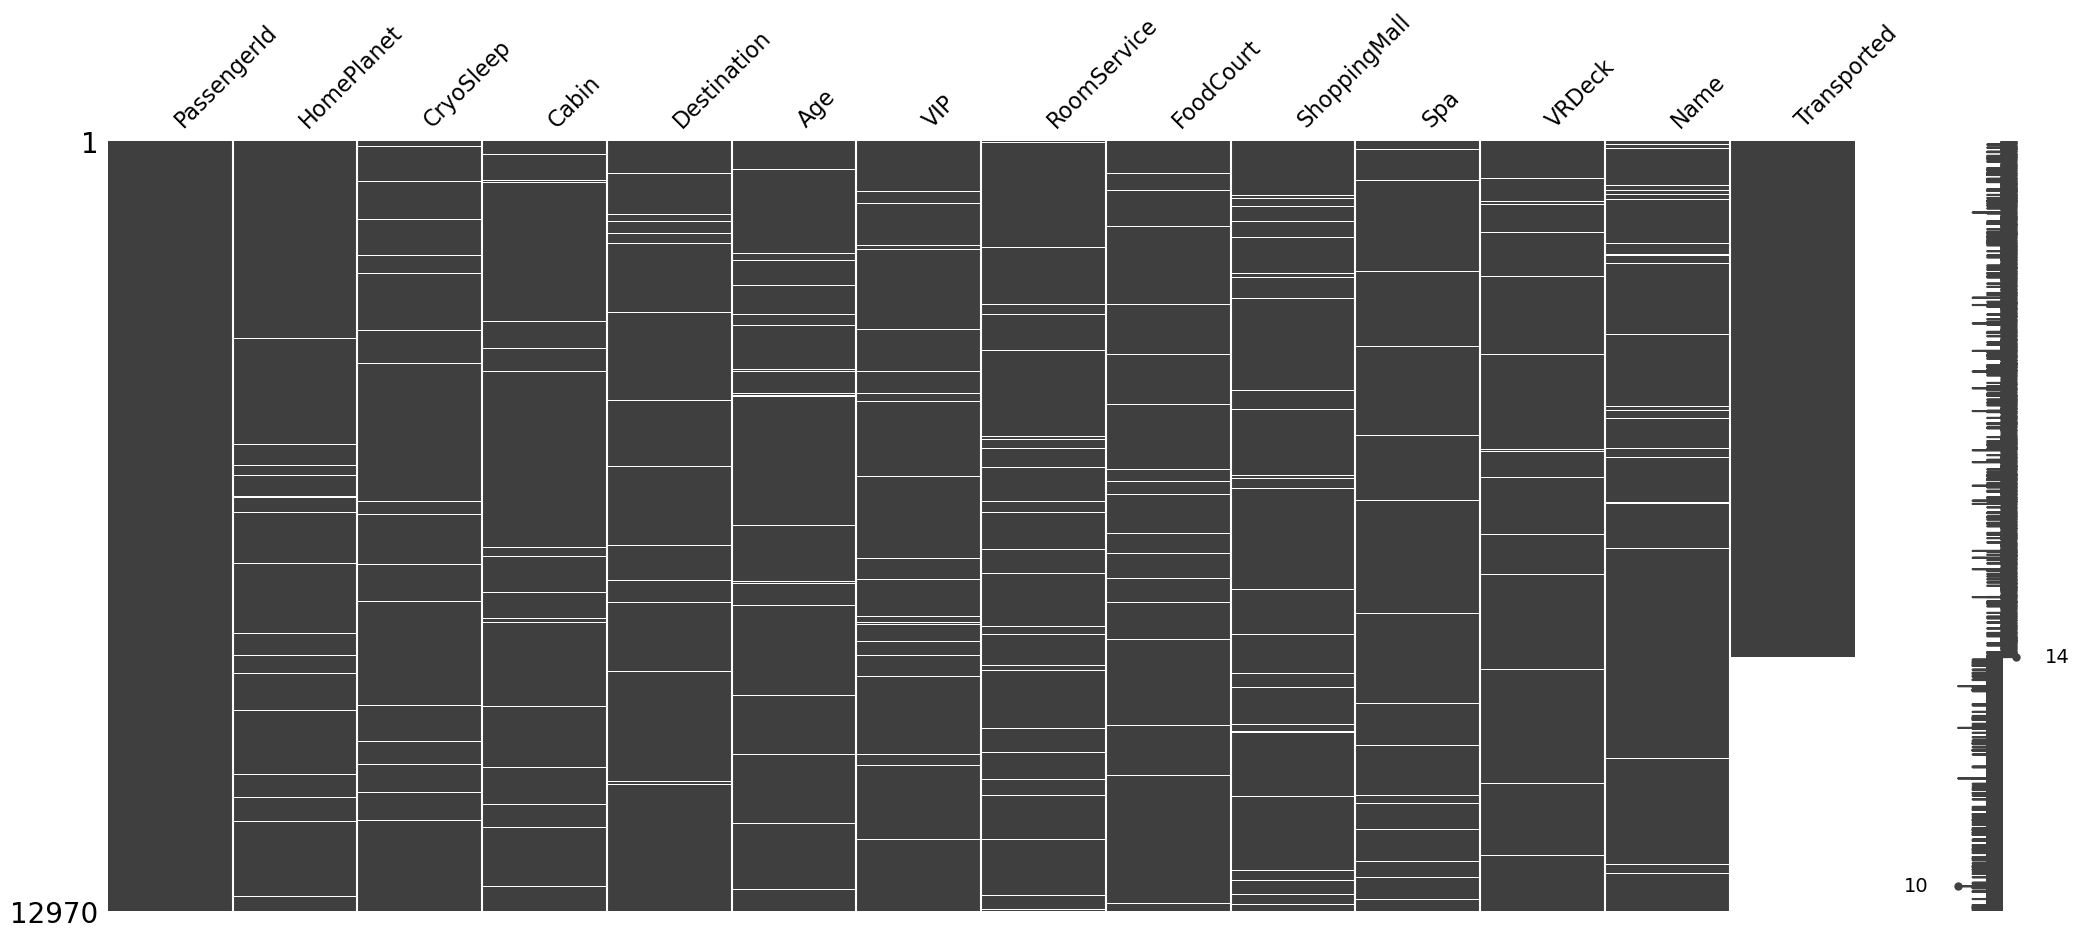

In [988]:
import missingno as msno
import matplotlib.pyplot as plt

# Print number of missing values in banking
print(data_unprocessed.isna().sum())

# Visualize missingness matrix
msno.matrix(data_unprocessed)
plt.show()

It seems that values are Missing At Random (Transported column is our target, it is missing in test data). We'll fill the missing values column by column, based on the description of the dataset.

## 04. Family Size

**Name** - The first and last names of the passenger.

We don't need the first names, so we'll strip them. 
Additionally, we may assume that passengers with the same last names in different Groups are not relatives. To avoid treating them as relatives, we will append Group names to all last names:

In [989]:
### !!!! FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

train = pd.concat([train, train_unprocessed['Name']], axis=1)
test = pd.concat([test, test_unprocessed['Name']], axis=1)

for data in [train, test]:
    data.Name = data.Name.str.split(' ', 1).str[1]
    data.Name = data.Name + data.Group

C:\Users\mikej\AppData\Local\Temp\ipykernel_37392\2091076608.py:7: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data.Name = data.Name.str.split(' ', 1).str[1]


We'll fill the missing values for Names based on the most common surname in their Group.
If a passenger is alone in their group, we'll name them by the name of their Group:

In [990]:
for data in [train, test]:
    # Iterate through all the rows with missing data
    for index in data[data['Name'].isna()].index:
        # Fill the missing values for lonely passengers:
        if len(data[data['Group'] == data.loc[index, 'Group']]) == 1:
            data.loc[index, "Name"] = data.loc[index, 'Group']
        # Fill the missing values for non-lonely passengers:
        else:
            data.loc[index, "Name"] = data[(data['Group'] == data.loc[index, 'Group']) & \
                    (data['Name'].isna() == False)]['Name'].mode()[0]

As you can see below, now Name doesn't have missing values:

In [991]:
for data in [train, test]:
    print(data['Name'].info())
    print(data['Name'].describe())
    print('Unique Values:')
    print(data['Name'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count               8693
unique              6491
top       Clemondsey9081
freq                   8
Name: Name, dtype: object
Unique Values:
['Ofracculy0001' 'Vines0002' 'Susent0003' ... 'Mondalley9278' 'Connon9279'
 'Hontichre9280']
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
4277 non-null   object
dtypes: object(1)
memory usage: 33.5+ KB
None
count          4277
unique         3200
top       Casez6332
freq              8
Name: Name, dtype: object
Unique Values:
['Carsoning0013' 'Peckers0018' 'Unhearfus0019' ... 'Pore9271' 'Conale9273'
 'Leonzaley9277']


Since we don't have common Groups between train and test, we don't have common families as well. Hence, we'll just create FamilySize feature:

In [992]:
for data in [train, test]:
    # Calculate FamilySize
    data['FamilySize'] = data.groupby('Name')['Name'].transform('count')
    print(data['FamilySize'].info())
    print(data['FamilySize'].describe())
    print('Unique Values:')
    print(data['FamilySize'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: FamilySize
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        1.819510
std         1.304256
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: FamilySize, dtype: float64
Unique Values:
[1 2 3 7 6 4 5 8]
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: FamilySize
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        1.771569
std         1.196133
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: FamilySize, dtype: float64
Unique Values:
[1 2 3 5 4 6 7 8]


Note, that GroupSize is not always equal to FamilySize:

In [993]:
(train['GroupSize'] - train['FamilySize']).value_counts()

0    7727
1     533
2     202
3      91
4      70
5      40
6      22
7       8
dtype: int64

In [994]:
(test['GroupSize'] - test['FamilySize']).value_counts()

0    3832
1     208
2      95
3      57
4      43
5      30
6       9
7       3
dtype: int64

Let's select features:

In [995]:
train.to_csv('new_datasets/train_04.csv')
test.to_csv('new_datasets/test_04.csv')

study = joblib.load("studies/04.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8342301402263921
Best hyperparameters: {'Age': True, 'RoomService': True, 'FoodCourt': True, 'ShoppingMall': True, 'Spa': True, 'VRDeck': True, 'GroupSize': True, 'FamilySize': True}


In [996]:
# Create sets with selected columns

selected_columns = []
for key, value in study.best_params.items():
    if value:
        selected_columns.append(key)

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]


train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="+ FamilySize")
submission.to_csv('submissions/submission_04.csv', index=False)
scores_df.loc[4, 'Test Accuracy'] = 0.78723
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  \
0                                           All True     0.500000   
1  All numerical features with 0's for missing va...     0.919507   
2                All numerical features are selected     0.919507   
3                                        + GroupSize     0.932251   
4                                       + FamilySize     0.935245   

   Cross-val Score  Test Accuracy  
0         0.500000        0.50689  
1         0.828452        0.78770  
2         0.828452        0.78770  
3         0.834209        0.78840  
4         0.834230        0.78723

This is the first time when increase in Cross-val Score didn't lead to increase in Test Accuracy. However, as we stated before, we won't look at Test Accuracy for making decisions, since we want our model to generalize well to unseen data (imagine there will be more passenger data in the future).

What is important for us, is that our Cross-val Score is increasing, and Test Accuracy is generally increasing, so we can't say that our Score calculations are bugged or that we are overfitting to the cross-validation sets.

## 05. The rest of categorical columns

**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**Destination** - The planet the passenger will be debarking to.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

It makes sense that these three features depend on Group and Name, so we'll fill the missing values accordingly. For lonely passengers, we'll fill these columns with the most common values (in the train set, to avoud data leakage).

We have three unique cases where the whole group has missing values. We'll fill them first:

In [997]:
# Add unprocessed columns
for column in ['HomePlanet', 'Destination', 'VIP', 'Cabin', 'CryoSleep']:
    train = pd.concat([train, train_unprocessed[column]], axis=1)
    test = pd.concat([test, test_unprocessed[column]], axis=1)

# Handle special cases
train.loc[6917:6918, 'HomePlanet'] = train['HomePlanet'].mode()[0]
train.loc[5778:5779, 'VIP'] = train['VIP'].mode()[0]
test.loc[4248:4249, 'Cabin'] = test['Cabin'].mode()[0]

In [998]:
# List of columns with missing values
columns_to_fill = ['HomePlanet', 'Destination', 'VIP', 'Cabin']

# Iterate through all columns with missing values
for column in columns_to_fill:
    # For two datasets
    for data in [train, test]:
        # Iterate through all the rows with missing data
        for index in data[data[column].isna()].index:
            # Fill the missing values for passengers alone in their group:
            if len(data[data['Group'] == data.loc[index, 'Group']]) == 1:
                data.loc[index, column] = train[column].mode()[0]
             # Fill the missing values for passengers with an unique last name:
            elif len(data[data['Name'] == data.loc[index, 'Name']]) == 1:
                data.loc[index, column] = data[(data['Group'] == data.loc[index, 'Group']) & \
                    (data[column].isna() == False)][column].mode()[0]
            # Fill the missing values for non-lonely passengers:
            else:
                data.loc[index, column] = data[(data['Group'] == data.loc[index, 'Group']) & \
                                (data['Name'] == data.loc[index, 'Name']) & \
                                (data[column].isna() == False)][column].mode()[0]

Let's check the filled columns:

In [999]:
for column in columns_to_fill:
    for data in [train, test]:
        print(data[column].info())
        print(data[column].describe())
        print('Unique Values:')
        print(data[column].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: HomePlanet
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count      8693
unique        3
top       Earth
freq       4745
Name: HomePlanet, dtype: object
Unique Values:
['Europa' 'Earth' 'Mars']
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: HomePlanet
Non-Null Count  Dtype 
--------------  ----- 
4277 non-null   object
dtypes: object(1)
memory usage: 33.5+ KB
None
count      4277
unique        3
top       Earth
freq       2326
Name: HomePlanet, dtype: object
Unique Values:
['Earth' 'Europa' 'Mars']
<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Destination
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count            8693
unique              3
top       TRAPPIST-1e
freq             6072
Name

Everything is good now, the first three columns are ready for encoding to numericals, but we want to extract the useful data from Cabin.

**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Let's extract Deck and Side:

In [1000]:
for data in [train, test]:
    data['Deck'] = data.Cabin.str[0]
    data['Side'] = data.Cabin.str[-1]

for column in ['Deck', 'Side']:
    for data in [train, test]:
        print(data[column].info())
        print(data[column].describe())
        print('Unique Values:')
        print(data[column].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Deck
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count     8693
unique       8
top          F
freq      2810
Name: Deck, dtype: object
Unique Values:
['B' 'F' 'A' 'G' 'E' 'D' 'C' 'T']
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: Deck
Non-Null Count  Dtype 
--------------  ----- 
4277 non-null   object
dtypes: object(1)
memory usage: 33.5+ KB
None
count     4277
unique       8
top          F
freq      1458
Name: Deck, dtype: object
Unique Values:
['G' 'F' 'C' 'B' 'D' 'E' 'A' 'T']
<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Side
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count     8693
unique       2
top          S
freq      4442
Name: Side, dtype: object
Unique Values:
['P' 'S']
<cla

Seems great. We may assume that Decks are labeled based on their position in the spacehip, so we can label them with numbers:

In [1001]:
# Label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

print('Deck encoding matches in train and test, see the first 10 rows:')
for data in [train, test]:
    data['Deck_enc'] = le.fit_transform(data['Deck'])
    print(data[['Deck', 'Deck_enc']].head(10))


Deck encoding matches in train and test, see the first 10 rows:
  Deck  Deck_enc
0    B         1
1    F         5
2    A         0
3    A         0
4    F         5
5    F         5
6    F         5
7    G         6
8    F         5
9    B         1
  Deck  Deck_enc
0    G         6
1    F         5
2    C         2
3    C         2
4    F         5
5    F         5
6    B         1
7    D         3
8    D         3
9    F         5


**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

I suspect that CryoSleep may be dependend on HomePlanet and Destination. Let's check:

In [1002]:
print('Ratio of CryoSleep passengers per route:')
pd.pivot_table(train, values='CryoSleep', index=['HomePlanet'], columns=["Destination"])

Ratio of CryoSleep passengers per route:


Destination  55 Cancri e  PSO J318.5-22  TRAPPIST-1e
HomePlanet                                          
Earth           0.310443       0.506259     0.263781
Europa          0.513636       0.473684     0.387043
Mars            0.411458       0.229167     0.393617

In [1003]:
import numpy as np

print('Standard Deviation of CryoSleep:', np.std(train['CryoSleep']))

Standard Deviation of CryoSleep: 0.47950261208567063


It seems that there is some dependency. We shall conduct a small statistical study to know for sure.

First, we'll create a feature Route, for 9 different routes. This feature will be categorical:

In [1004]:
for data in [train, test]:
    data['Route'] = data['HomePlanet'] + data['Destination']
    
print('Unique Routes:')
print(train['Route'].unique())

print('Amount of CryoSleep passengers per route:')
train.groupby('Route')['CryoSleep'].value_counts()

Unique Routes:
['EuropaTRAPPIST-1e' 'EarthTRAPPIST-1e' 'EarthPSO J318.5-22'
 'Europa55 Cancri e' 'MarsTRAPPIST-1e' 'Mars55 Cancri e'
 'Earth55 Cancri e' 'MarsPSO J318.5-22' 'EuropaPSO J318.5-22']
Amount of CryoSleep passengers per route:


Route                CryoSleep
Earth55 Cancri e     False         482
                     True          217
EarthPSO J318.5-22   True          364
                     False         355
EarthTRAPPIST-1e     False        2364
                     True          847
Europa55 Cancri e    True          452
                     False         428
EuropaPSO J318.5-22  False          10
                     True            9
EuropaTRAPPIST-1e    False         738
                     True          466
Mars55 Cancri e      False         113
                     True           79
MarsPSO J318.5-22    False          37
                     True           11
MarsTRAPPIST-1e      False         912
                     True          592
Name: CryoSleep, dtype: int64

ANOVA test:

H_0: Ratios of CryoSleep passengers for each route are the same.

H_A:Ratios of CryoSleep passengers for each route are are different.

Significance level: 0.1.

In [1005]:
# UNCOMMENT TO INSTALL PINGOUIN
# !pip install pingouin

# Convert CryoSleep to numneric
for data in [train, test]:
    data['CryoSleep'] = [1 if i else 0 for i in data['CryoSleep']]

import pingouin

# Run an ANOVA
pingouin.anova(data=train, dv="CryoSleep", between="Route")

Source  ddof1  ddof2          F         p-unc       np2
0  Route      8   8684  38.580434  7.818927e-61  0.034322

In [1006]:
# Kruskal-Wallis test 
pingouin.kruskal(data=train, dv="CryoSleep", between="Route")

Source  ddof1           H         p-unc
Kruskal  Route      8  298.324852  9.357762e-60

It is safe to assume that CryoSleep depends on Route. Let's fill missing values based on Route, making sure to avoid data leakage (mode of the categories is calculated based on the train set only):

In [1007]:
for data in [train, test]:
    # Iterate through all the rows with missing data
    for index in data[data['CryoSleep'].isna()].index:
        # Fill the missing values:
        data.loc[index, "CryoSleep"] = \
            train[(train['HomePlanet'] == data.loc[index, 'HomePlanet']) & \
                  (train['Destination'] == data.loc[index, 'Destination']) & \
                  (train['CryoSleep'].isna() == False)]['CryoSleep'].mode()[0]

    print(data['CryoSleep'].info())
    print(data['CryoSleep'].describe())
    print('Unique Values:')
    print(data['CryoSleep'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: CryoSleep
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        0.374324
std         0.483976
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: CryoSleep, dtype: float64
Unique Values:
[0 1]
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: CryoSleep
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        0.382745
std         0.486114
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: CryoSleep, dtype: float64
Unique Values:
[1 0]


Let's look at the current results of the validation and cleaning:

In [1008]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           8693 non-null   float64
 1   RoomService   8693 non-null   float64
 2   FoodCourt     8693 non-null   float64
 3   ShoppingMall  8693 non-null   float64
 4   Spa           8693 non-null   float64
 5   VRDeck        8693 non-null   float64
 6   Transported   8693 non-null   int64  
 7   Group         8693 non-null   object 
 8   Group_enc     8693 non-null   float64
 9   GroupSize     8693 non-null   int64  
 10  Name          8693 non-null   object 
 11  FamilySize    8693 non-null   int64  
 12  HomePlanet    8693 non-null   object 
 13  Destination   8693 non-null   object 
 14  VIP           8693 non-null   object 
 15  Cabin         8693 non-null   object 
 16  CryoSleep     8693 non-null   int64  
 17  Deck          8693 non-null   object 
 18  Side          8693 non-null 

In [1009]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           4277 non-null   float64
 1   RoomService   4277 non-null   float64
 2   FoodCourt     4277 non-null   float64
 3   ShoppingMall  4277 non-null   float64
 4   Spa           4277 non-null   float64
 5   VRDeck        4277 non-null   float64
 6   Group         4277 non-null   object 
 7   Group_enc     4277 non-null   float64
 8   GroupSize     4277 non-null   int64  
 9   Name          4277 non-null   object 
 10  FamilySize    4277 non-null   int64  
 11  HomePlanet    4277 non-null   object 
 12  Destination   4277 non-null   object 
 13  VIP           4277 non-null   object 
 14  Cabin         4277 non-null   object 
 15  CryoSleep     4277 non-null   int64  
 16  Deck          4277 non-null   object 
 17  Side          4277 non-null   object 
 18  Deck_enc      4277 non-null 

None of the categorical columns have missing values.

Now, let's create dummy variables for categorical data and test if they'll benefit our performance:

In [1010]:
binary_columns = ['VIP', 'CryoSleep']

for data in [train, test]:
    for column in binary_columns:
        data[column] = [1 if i else 0 for i in data[column]]

categorical_columns = ['HomePlanet', 'Destination', 'Side']


for column in categorical_columns:
    dummies = pd.get_dummies(train[column], drop_first=True)
    train = pd.concat([train, dummies], axis = 1)
    dummies = pd.get_dummies(test[column], drop_first=True)
    test = pd.concat([test, dummies], axis = 1)

print(train.head())
print(train['VIP'].head())
print(test.head())
test['VIP'].unique()


    Age  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Transported  \
0  39.0          0.0        0.0           0.0     0.0     0.0            0   
1  24.0        109.0        9.0          25.0   549.0    44.0            1   
2  58.0         43.0     3576.0           0.0  6715.0    49.0            0   
3  33.0          0.0     1283.0         371.0  3329.0   193.0            0   
4  16.0        303.0       70.0         151.0   565.0     2.0            1   

  Group  Group_enc  GroupSize  ... CryoSleep  Deck Side Deck_enc  \
0  0001   0.503595          1  ...         0     B    P        1   
1  0002   0.503595          1  ...         0     F    S        5   
2  0003   0.444412          2  ...         0     A    S        0   
3  0003   0.444349          2  ...         0     A    S        0   
4  0004   0.503666          1  ...         0     F    S        5   

               Route Europa  Mars PSO J318.5-22 TRAPPIST-1e  S  
0  EuropaTRAPPIST-1e      1     0             0          

array([0, 1], dtype=int64)

In [1011]:
train.to_csv('new_datasets/train_05.csv')
test.to_csv('new_datasets/test_05.csv')

study = joblib.load("studies/05.pkl")

best_params_05 = study.best_params

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8629191041191197
Best hyperparameters: {'Age': False, 'RoomService': True, 'FoodCourt': True, 'ShoppingMall': True, 'Spa': True, 'VRDeck': True, 'GroupSize': False, 'VIP': True, 'CryoSleep': True, 'Europa': True, 'Mars': True, 'PSO J318.5-22': True, 'TRAPPIST-1e': True, 'S': True}


As we can see, some of the columns were rejected, but it may be due to the fact that computing all the variants takes too much time and we are stuck in a local maximum. We'll conduct another study, in which we'll accept by default all the accepted columns, and we''l test if adding rejected columns is beneficial:

In [1012]:
study = joblib.load("studies/05_2.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8697466002712255
Best hyperparameters: {'Age': True, 'GroupSize': True}


Indeed, all our features are accepted! Let's put the new Scores in the table:

In [1013]:
# Create sets with selected columns

selected_columns = []
for key, value in best_params_05.items():
    if value:
        selected_columns.append(key)
for key, value in study.best_params.items():
    if value:
        selected_columns.append(key)
        


train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]


train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="+ All categorical features")
submission.to_csv('submissions/submission_05.csv', index=False)
scores_df.loc[5, 'Test Accuracy'] = 0.78372
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  \
0                                           All True     0.500000   
1  All numerical features with 0's for missing va...     0.919507   
2                All numerical features are selected     0.919507   
3                                        + GroupSize     0.932251   
4                                       + FamilySize     0.935245   
5                         + All categorical features     0.965743   

   Cross-val Score  Test Accuracy  
0         0.500000        0.50689  
1         0.828452        0.78770  
2         0.828452        0.78770  
3         0.834209        0.78840  
4         0.834230        0.78723  
5         0.869747        0.78372

## 06. Filling numerical features

At the beginning of Part 4, we filled missing values in our numerical features with 0's. 

What if we try more elaborate filling strategies?

**RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Almost all passengers with CryoSleep == True do not spend money on servises. Here is the 99th quantiles:

In [1014]:
print(train[train['CryoSleep'] == 1].quantile(0.99, numeric_only=True))

Age               65.000000
RoomService      353.390000
FoodCourt        773.700000
ShoppingMall     249.290000
Spa              233.890000
VRDeck           182.290000
Transported        1.000000
Group_enc          0.645476
GroupSize          8.000000
FamilySize         7.000000
VIP                0.000000
CryoSleep          1.000000
Deck_enc           6.000000
Europa             1.000000
Mars               1.000000
PSO J318.5-22      1.000000
TRAPPIST-1e        1.000000
S                  1.000000
Name: 0.99, dtype: float64


Therefore, we can fill missing values with 0's for such passengers.

In [1015]:
# Collect unprocessed "Age" to train and test
train['Age'] = train_unprocessed['Age']
test['Age'] = test_unprocessed['Age']

# For each category of spendings
for column in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    # Collect unprocessed columns to train and test
    train[column] = train_unprocessed[column]
    test[column] = test_unprocessed[column]
    # Zeros for passengers in CryoSleep
    train.loc[train['CryoSleep'] == True, column].fillna(0, inplace = True)
    test.loc[test['CryoSleep'] == True, column].fillna(0, inplace = True)

print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            8514 non-null   float64
 1   RoomService    8512 non-null   float64
 2   FoodCourt      8510 non-null   float64
 3   ShoppingMall   8485 non-null   float64
 4   Spa            8510 non-null   float64
 5   VRDeck         8505 non-null   float64
 6   Transported    8693 non-null   int64  
 7   Group          8693 non-null   object 
 8   Group_enc      8693 non-null   float64
 9   GroupSize      8693 non-null   int64  
 10  Name           8693 non-null   object 
 11  FamilySize     8693 non-null   int64  
 12  HomePlanet     8693 non-null   object 
 13  Destination    8693 non-null   object 
 14  VIP            8693 non-null   int64  
 15  Cabin          8693 non-null   object 
 16  CryoSleep      8693 non-null   int64  
 17  Deck           8693 non-null   object 
 18  Side    

How about prices for services of VIP vs not VIP?

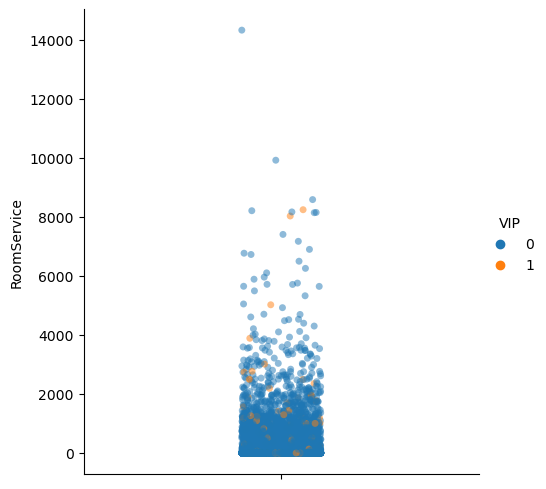

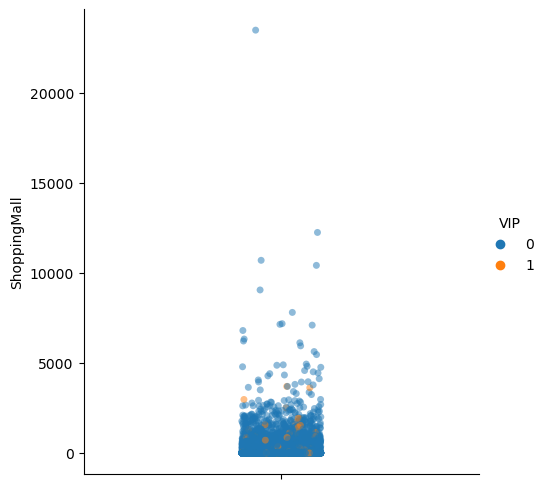

In [1016]:
import seaborn as sns

sns.catplot(data=train, y='RoomService', hue='VIP', alpha = 0.5)
sns.catplot(data=train, y='ShoppingMall', hue='VIP', alpha = 0.5)

It seems that VIP status doesn't affect spendings much. Let's look for other correlations, but first let's introduce a feature TotalSpendings:

In [1017]:
train['TotalSpendings'] = train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize']].sum(axis=1)
test['TotalSpendings'] = test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupSize']].sum(axis=1)

print(train['TotalSpendings'].info())
train['TotalSpendings'].describe()

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: TotalSpendings
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None


count     8693.000000
mean      1442.901875
std       2803.065832
min          1.000000
25%          2.000000
50%        718.000000
75%       1443.000000
max      35988.000000
Name: TotalSpendings, dtype: float64

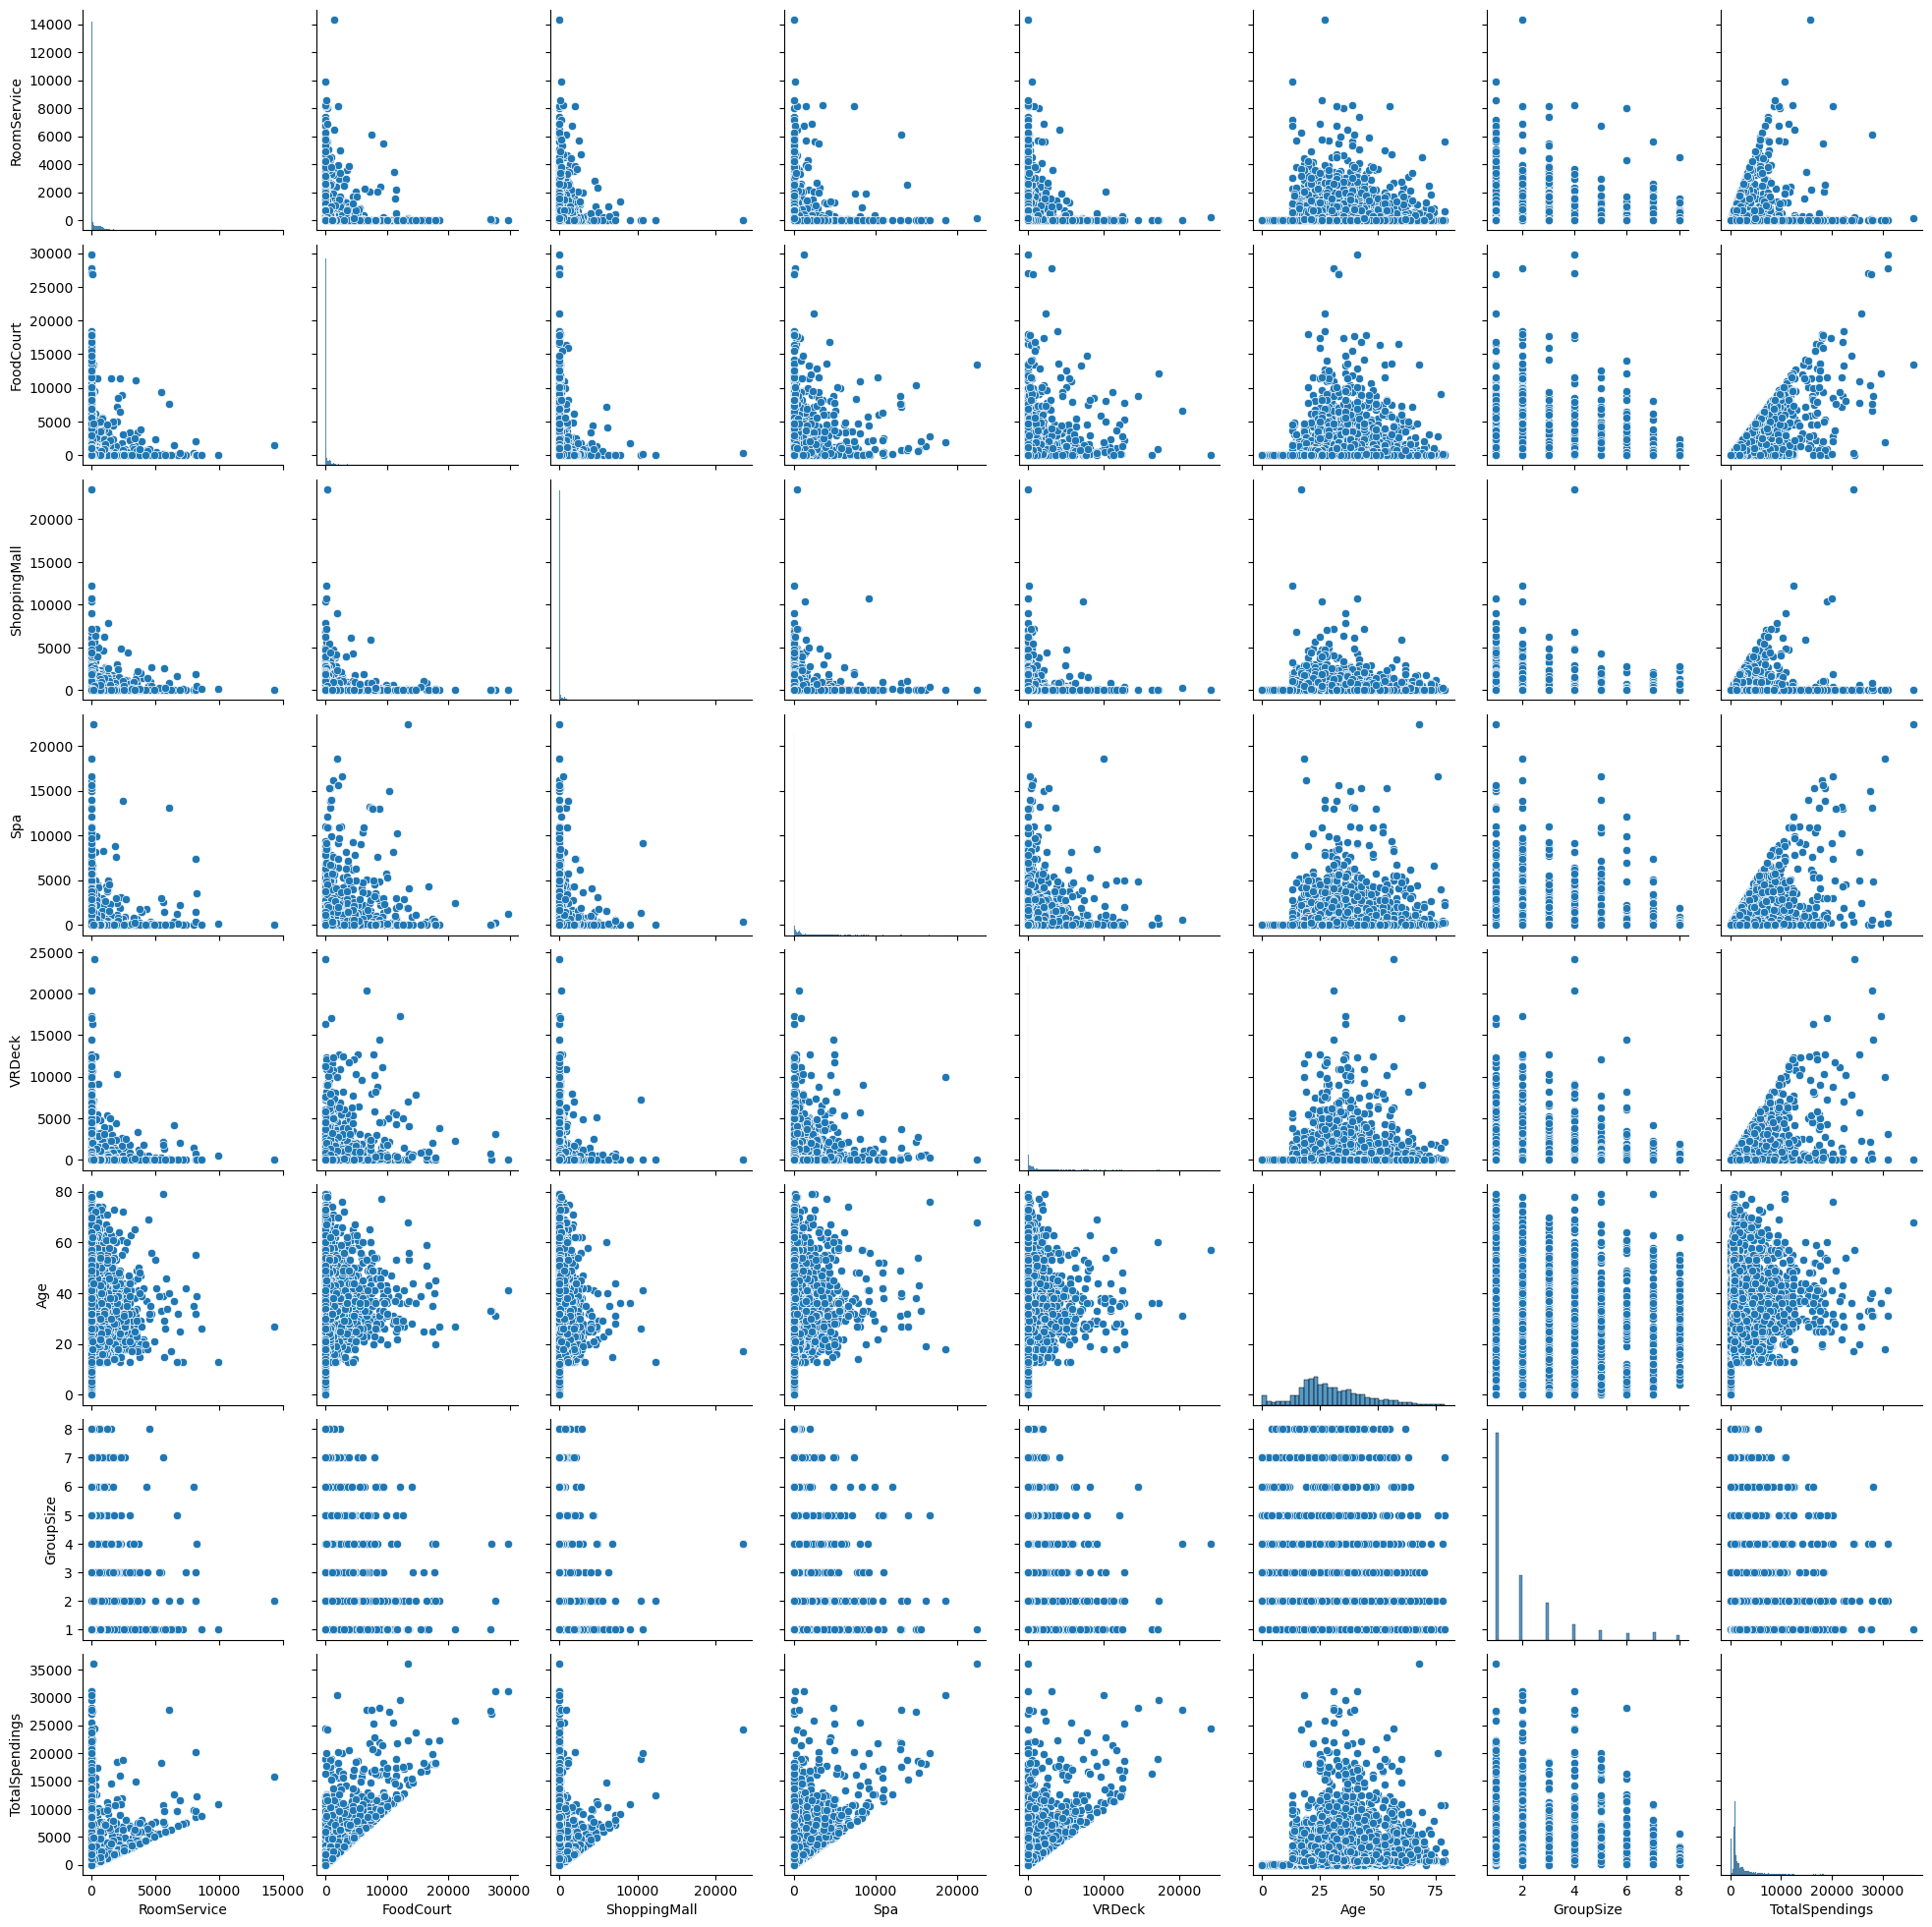

CPU times: total: 15.9 s
Wall time: 17.5 s


In [1018]:
%%time

import matplotlib.pyplot as plt

# Plot pairwise relationships
sns.pairplot(train.loc[train['CryoSleep'] == False, ['RoomService', 'FoodCourt', \
                                                    'ShoppingMall', 'Spa', 'VRDeck', \
                                                    'Age', 'GroupSize', 'TotalSpendings']])

# Show plot
plt.show()

First, we see that spendings in different categories don't really corelate with each other or with TotalSpendings.

However, we see that all of them show the same pattern with Age. Let's look at this pattern more closely:

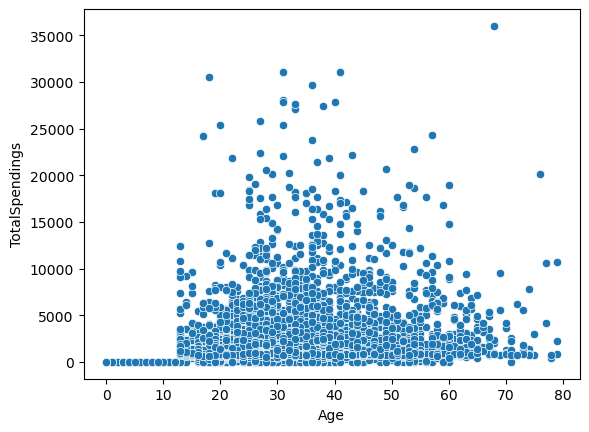

In [1019]:
# Plot pairwise relationships
sns.scatterplot(data = train[train['CryoSleep'] == False], x='Age', y='TotalSpendings')

# Show plot
plt.show()

In [1020]:
print('Median spendings of kids, teens and adults:')

print(train.loc[train['Age'] < 14, 'TotalSpendings'].median())
print(train.loc[(train['Age'] >= 14) & (train['Age']  <= 19), 'TotalSpendings'].median())
print(train.loc[train['Age'] > 21, 'TotalSpendings'].median())

Median spendings of kids, teens and adults:
3.0
698.0
805.0


We see that kids almost don't spend, and adults spend more than teens.

1) We'll create AgeGroup, with values 0 for kids, 1 for teens and 2 for adults

1) We'll fill missing TotalSpendings according to median TotalSpendings for their AgeGroup (calculated on the train set, to prevent data leakage)

2) Missing spendings per category will be 0, because median spendings per category are 0

3) We'll fill missing Age values according to their TotalSpendings (calculated on the train set, to prevent data leakage)

Let's procceed:

In [1021]:
# create AgeGroup, with values 0 for kids, 1 for teens and 2 for adults

for data in [train, test]:
    data['AgeGroup'] = [0 if age < 14 else 1 if (age >= 14) and (age < 21) \
                        else 2 if age >= 21 else np.nan for age in data['Age']]
    print(data['AgeGroup'].info())
    print(data['AgeGroup'].describe())
    print('Unique Values:')
    print(data['AgeGroup'].value_counts())
    

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: AgeGroup
Non-Null Count  Dtype  
--------------  -----  
8514 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None
count    8514.000000
mean        1.602772
std         0.679669
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: AgeGroup, dtype: float64
Unique Values:
2.0    6079
1.0    1488
0.0     947
Name: AgeGroup, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: AgeGroup
Non-Null Count  Dtype  
--------------  -----  
4186 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None
count    4186.000000
mean        1.606785
std         0.666087
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: AgeGroup, dtype: float64
Unique Values:
2.0    2969
1.0     788
0.0     429
Name: AgeGroup, dtype: int64


In [1022]:
# fill missing TotalSpendings according to median spendings for their AgeGroup

# Save median spendings into variables
median = train['TotalSpendings'].median()
median_by_age_group = {group: train.loc[train["AgeGroup"] == group, 'TotalSpendings'].median() \
                      for group in train["AgeGroup"].dropna().unique()}

print(median_by_age_group)

# If AgeGroup is missing, fill with median spendings for all
train.loc[train['AgeGroup'].isna(), 'TotalSpendings'] = median
test.loc[test['AgeGroup'].isna(), 'TotalSpendings'] = median

# Iterate through all the rows with missing data
for index in train[train['TotalSpendings'].isna()].index:
    # If AgeGroup is present, fill with mean spendings for their AgeGroup
    train.loc[index, 'TotalSpendings'] = median_by_age_group[train.loc[index, 'AgeGroup']]

print(train['TotalSpendings'].info())
print(train['TotalSpendings'].describe())

# Iterate through all the rows with missing data
for index in test[test['TotalSpendings'].isna()].index:
    # If Age is present, fill with mean spendings for their Age
    test.loc[index, 'TotalSpendings'] = median_by_age_group[train.loc[index, 'AgeGroup']]

print(test['TotalSpendings'].info())
print(test['TotalSpendings'].describe())


{2.0: 804.0, 1.0: 707.0, 0.0: 3.0}
<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: TotalSpendings
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None
count     8693.000000
mean      1430.933625
std       2774.836167
min          1.000000
25%          2.000000
50%        718.000000
75%       1419.000000
max      35988.000000
Name: TotalSpendings, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: TotalSpendings
Non-Null Count  Dtype  
--------------  -----  
4277 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None
count     4277.000000
mean      1401.775310
std       2779.019097
min          1.000000
25%          2.000000
50%        718.000000
75%       1409.000000
max      33668.000000
Name: TotalSpendings, dtype: float64


In [1023]:
#  fill missing Age values according to their TotalSpendings

# Save median ages to a list
median = [train.loc[train['Age'] < 14, 'Age'].median(), train.loc[(train['Age'] > 14) & \
                                                (train['Age']  <= 19), 'Age'].median(),
                                             train.loc[train['Age'] > 21, 'Age'].median()]

for data in [train, test]:

    # Iterate through all the rows with missing data
    for index in data[data['Age'].isna()].index:
        # fill
        if data.loc[index, 'TotalSpendings'] < 698.0:
            data.loc[index, 'Age'] = median[0]
        elif data.loc[index, 'TotalSpendings'] < 805.0:
            data.loc[index, 'Age'] = median[1]
        else:
            data.loc[index, 'Age'] = median[2]


print(train['Age'].info())
print(train['Age'].describe())
print(test['Age'].info())
print(test['Age'].describe())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
8693 non-null   float64
dtypes: float64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean       28.604970
std        14.421278
min         0.000000
25%        19.000000
50%        27.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
4277 non-null   float64
dtypes: float64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean       28.431377
std        14.111469
min         0.000000
25%        19.000000
50%        26.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64


In [1024]:
# Recalculate AgeGroup

for data in [train, test]:
    data['AgeGroup'] = [0 if age < 14 else 1 if (age >= 14) and (age < 21) \
                        else 2 if age >= 21 else np.nan for age in data['Age']]
    print(data['AgeGroup'].info())
    print(data['AgeGroup'].describe())
    print('Unique Values:')
    print(data['AgeGroup'].value_counts())
    

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: AgeGroup
Non-Null Count  Dtype
--------------  -----
8693 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB
None
count    8693.000000
mean        1.590360
std         0.678059
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: AgeGroup, dtype: float64
Unique Values:
2    6079
1    1667
0     947
Name: AgeGroup, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 4277 entries, 0 to 4276
Series name: AgeGroup
Non-Null Count  Dtype
--------------  -----
4277 non-null   int64
dtypes: int64(1)
memory usage: 33.5 KB
None
count    4277.000000
mean        1.593874
std         0.664755
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: AgeGroup, dtype: float64
Unique Values:
2    2969
1     879
0     429
Name: AgeGroup, dtype: int64


In [1025]:
# Fill missing values with zeros
train = train.fillna(0)
test = test.fillna(0)

Great, now we don't have any missing values:

In [1026]:
print(train.info())
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             8693 non-null   float64
 1   RoomService     8693 non-null   float64
 2   FoodCourt       8693 non-null   float64
 3   ShoppingMall    8693 non-null   float64
 4   Spa             8693 non-null   float64
 5   VRDeck          8693 non-null   float64
 6   Transported     8693 non-null   int64  
 7   Group           8693 non-null   object 
 8   Group_enc       8693 non-null   float64
 9   GroupSize       8693 non-null   int64  
 10  Name            8693 non-null   object 
 11  FamilySize      8693 non-null   int64  
 12  HomePlanet      8693 non-null   object 
 13  Destination     8693 non-null   object 
 14  VIP             8693 non-null   int64  
 15  Cabin           8693 non-null   object 
 16  CryoSleep       8693 non-null   int64  
 17  Deck            8693 non-null   o

Let's check if this way of filling missing values is more beneficial:

In [1027]:

train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]


train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="New filling of numerical features")
submission.to_csv('submissions/submission_06.csv', index=False)
scores_df.loc[6, 'Test Accuracy'] = 0.79191
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  \
0                                           All True     0.500000   
1  All numerical features with 0's for missing va...     0.919507   
2                All numerical features are selected     0.919507   
3                                        + GroupSize     0.932251   
4                                       + FamilySize     0.935245   
5                         + All categorical features     0.965743   
6                  New filling of numerical features     0.967151   

   Cross-val Score  Test Accuracy  
0         0.500000        0.50689  
1         0.828452        0.78770  
2         0.828452        0.78770  
3         0.834209        0.78840  
4         0.834230        0.78723  
5         0.869747        0.78372  
6         0.867827        0.79191

Here, our Test Accuracy increased, but, as we said before, we don't want to overfit to the test set, so, since our Cross-val score dropped, we won't use this variant of filling.

## 07. Filling Age with median

Let's try to fill missing values for Age with median age in the training test, and the rest of missing values with 0's (since medians are 0's):

In [1028]:
# Collect unprocessed "Age" to train and test and fill with medians
train['Age'] = train_unprocessed['Age']
train.loc[train['Age'].isna(), 'Age'] = train['Age'].median()
test['Age'] = test_unprocessed['Age']
test.loc[test['Age'].isna(), 'Age'] = train['Age'].median()

# For each category of spendings
for column in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    # Collect unprocessed columns to train and test
    train[column] = train_unprocessed[column]
    test[column] = test_unprocessed[column]
    
# Fill the rest of missing values with zeros
train = train.fillna(0)
test = test.fillna(0)

train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             8693 non-null   float64
 1   RoomService     8693 non-null   float64
 2   FoodCourt       8693 non-null   float64
 3   ShoppingMall    8693 non-null   float64
 4   Spa             8693 non-null   float64
 5   VRDeck          8693 non-null   float64
 6   Transported     8693 non-null   int64  
 7   Group           8693 non-null   object 
 8   Group_enc       8693 non-null   float64
 9   GroupSize       8693 non-null   int64  
 10  Name            8693 non-null   object 
 11  FamilySize      8693 non-null   int64  
 12  HomePlanet      8693 non-null   object 
 13  Destination     8693 non-null   object 
 14  VIP             8693 non-null   int64  
 15  Cabin           8693 non-null   object 
 16  CryoSleep       8693 non-null   int64  
 17  Deck            8693 non-null   o

In [1029]:
train_selected = train[selected_columns]
train_selected = pd.concat([train_selected, train_unprocessed['Transported']], axis=1)
test_selected =  test[selected_columns]

train_selected.to_csv('new_datasets/train_07.csv')
test_selected.to_csv('new_datasets/test_07.csv')

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="5 + filled Age with medians")
submission.to_csv('submissions/submission_07.csv', index=False)
scores_df.loc[7, 'Test Accuracy'] =  0.78372
scores_df.to_csv('scores_df.csv')
scores_df

Comment  Train Score  \
0                                           All True     0.500000   
1  All numerical features with 0's for missing va...     0.919507   
2                All numerical features are selected     0.919507   
3                                        + GroupSize     0.932251   
4                                       + FamilySize     0.935245   
5                         + All categorical features     0.965743   
6                  New filling of numerical features     0.967151   
7                        5 + filled Age with medians     0.966728   

   Cross-val Score  Test Accuracy  
0         0.500000        0.50689  
1         0.828452        0.78770  
2         0.828452        0.78770  
3         0.834209        0.78840  
4         0.834230        0.78723  
5         0.869747        0.78372  
6         0.867827        0.79191  
7         0.868260        0.78372

## 08. Tuning of XGBoost

Now, let's tune our XGBoost classifier:

In [1030]:
study = joblib.load("studies/08.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8836204108137425
Best hyperparameters: {'max_depth': 40, 'max_leaves': 82, 'grow_policy': 'lossguide', 'learning_rate': 0.08, 'booster': 'gbtree', 'tree_method': 'hist', 'gamma': 4.576721508009145, 'min_child_weight': 0.3292183344037119, 'subsample': 0.7, 'colsample_bytree': 0.85}


As always, let's put this into our table:

In [1031]:
%%time

# Instantiate the classifier
model = xgb.XGBClassifier(random_state=SEED, n_jobs=-1, **study.best_params)

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="XGBoost tuned")
submission.to_csv('submissions/submission_08.csv', index=False)
scores_df.loc[8, 'Test Accuracy'] =  0.79588
scores_df.to_csv('scores_df.csv')
scores_df

CPU times: total: 2.75 s
Wall time: 304 ms


Comment  Train Score  \
0                                           All True     0.500000   
1  All numerical features with 0's for missing va...     0.919507   
2                All numerical features are selected     0.919507   
3                                        + GroupSize     0.932251   
4                                       + FamilySize     0.935245   
5                         + All categorical features     0.965743   
6                  New filling of numerical features     0.967151   
7                        5 + filled Age with medians     0.966728   
8                                      XGBoost tuned     0.905151   

   Cross-val Score  Test Accuracy  
0         0.500000        0.50689  
1         0.828452        0.78770  
2         0.828452        0.78770  
3         0.834209        0.78840  
4         0.834230        0.78723  
5         0.869747        0.78372  
6         0.867827        0.79191  
7         0.868260        0.78372  
8         0.883620        0.79588

After several minutes of tuning, we see improvemets.

## 09. Expensive XGBoost

Now, we can try found hyperparameters with more computationally expensive setup: we'll choose number of estimators in range (100, 500) and add 'exact' tree method as an option. We won't change other parameters:

In [1032]:
study = joblib.load("studies/09.pkl")

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8839666105465384
Best hyperparameters: {'n_estimators': 300, 'tree_method': 'hist'}


In [1033]:
%%time

# Change the parameters
model.set_params(**study.best_params)

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="XGBoost expensive")
submission.to_csv('submissions/submission_09.csv', index=False)
scores_df.loc[9, 'Test Accuracy'] =  0.79915
scores_df.to_csv('scores_df.csv')
scores_df



CPU times: total: 4.97 s
Wall time: 477 ms


Comment  Train Score  \
0                                           All True     0.500000   
1  All numerical features with 0's for missing va...     0.919507   
2                All numerical features are selected     0.919507   
3                                        + GroupSize     0.932251   
4                                       + FamilySize     0.935245   
5                         + All categorical features     0.965743   
6                  New filling of numerical features     0.967151   
7                        5 + filled Age with medians     0.966728   
8                                      XGBoost tuned     0.905151   
9                                  XGBoost expensive     0.905676   

   Cross-val Score  Test Accuracy  
0         0.500000        0.50689  
1         0.828452        0.78770  
2         0.828452        0.78770  
3         0.834209        0.78840  
4         0.834230        0.78723  
5         0.869747        0.78372  
6         0.867827        0.79191  
7         0.868260        0.78372  
8         0.883620        0.79588  
9         0.883967        0.79915

 Let's try to tune different classifiers:

## 10. Tuning of Random Forests

In [1034]:
study_number = 10

study = joblib.load("studies/{}.pkl".format(study_number))

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

Best average cross-validation Score: 0.8803923475958179
Best hyperparameters: {'criterion': 'log_loss', 'max_depth': 44, 'max_features': 6, 'max_leaf_nodes': 443, 'min_impurity_decrease': 1.0589275371663915e-09, 'min_samples_leaf': 3, 'ccp_alpha': 0.0010619054629917488, 'max_samples': 0.9846315931336822}


In [1035]:
%%time

# Instantiate the classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=SEED,
                               n_estimators=90,
                               n_jobs=-1,
                               **study.best_params
                               )

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="RandomForests tuned")
submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  0.79869
scores_df.to_csv('scores_df.csv')
scores_df



CPU times: total: 609 ms
Wall time: 942 ms


Comment  Train Score  \
0                                            All True     0.500000   
1   All numerical features with 0's for missing va...     0.919507   
2                 All numerical features are selected     0.919507   
3                                         + GroupSize     0.932251   
4                                        + FamilySize     0.935245   
5                          + All categorical features     0.965743   
6                   New filling of numerical features     0.967151   
7                         5 + filled Age with medians     0.966728   
8                                       XGBoost tuned     0.905151   
9                                   XGBoost expensive     0.905676   
10                                RandomForests tuned     0.932646   

    Cross-val Score  Test Accuracy  
0          0.500000        0.50689  
1          0.828452        0.78770  
2          0.828452        0.78770  
3          0.834209        0.78840  
4          0.834230        0.78723  
5          0.869747        0.78372  
6          0.867827        0.79191  
7          0.868260        0.78372  
8          0.883620        0.79588  
9          0.883967        0.79915  
10         0.880392        0.79869

## 11. Expensive Random Forests

We'll test the found hyperparameters with number of estimators from 100 to 500 and add 'entropy' as an option for measuring quality of split:

In [1036]:
study_number = 11

study = joblib.load("studies/{}.pkl".format(study_number))

print("Best average cross-validation Score:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)


Best average cross-validation Score: 0.8806594661089078
Best hyperparameters: {'n_estimators': 200, 'criterion': 'log_loss'}


In [1037]:
%%time

# Change the parameters
model.set_params(**study.best_params)

train_score, cross_score, cross_scores_std, submission = get_score(global_variables, 
                                    train_selected, test_selected,
                                    model, scores_df,
                                    comment="RandomForests expensive")
submission.to_csv('submissions/submission_{}.csv'.format(study_number), index=False)
scores_df.loc[study_number, 'Test Accuracy'] =  0.79869
scores_df.to_csv('scores_df.csv')
scores_df



CPU times: total: 1.64 s
Wall time: 1.91 s


Comment  Train Score  \
0                                            All True     0.500000   
1   All numerical features with 0's for missing va...     0.919507   
2                 All numerical features are selected     0.919507   
3                                         + GroupSize     0.932251   
4                                        + FamilySize     0.935245   
5                          + All categorical features     0.965743   
6                   New filling of numerical features     0.967151   
7                         5 + filled Age with medians     0.966728   
8                                       XGBoost tuned     0.905151   
9                                   XGBoost expensive     0.905676   
10                                RandomForests tuned     0.932646   
11                            RandomForests expensive     0.933272   

    Cross-val Score  Test Accuracy  
0          0.500000        0.50689  
1          0.828452        0.78770  
2          0.828452        0.78770  
3          0.834209        0.78840  
4          0.834230        0.78723  
5          0.869747        0.78372  
6          0.867827        0.79191  
7          0.868260        0.78372  
8          0.883620        0.79588  
9          0.883967        0.79915  
10         0.880392        0.79869  
11         0.880659        0.79869

## 12. Logistic Regression without normalization

Next, we'll try Logistic Regression classifier, without normalizing features.